# Federated Learning

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from kernel import Kernel

from onlineKernels.klmsRFF import *
from onlineKernels.knlmsRFF import *
from onlineKernels.krlsRFF import *

# Multiprocessing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [2]:
def generate_data(num_data):
    # AWGN
    v = 0.1*np.random.normal(size=num_data+2) 

    # Initial conditions
    d_true =[0.1 , 0.1]
    d = [d_true[0] + v[0], d_true[1] + v[1]]

    # Grab new data
    new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + 0.9*np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
    for i in range(2,num_data+2):
        new_d_true(d_true)
        d.append(d_true[-1] + v[i])

    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))
    d_true = d_true[2::]
    d = d[2::]
    return np.array(u),np.array(d),np.array(d_true)

# Parameters
num_data = 3000
kernel = Kernel(3.73)

step_size = 0.7
reg_coeff = 0.1
threshold = 0.5

100%|████████████████████████████████████| 3000/3000 [00:00<00:00, 18190.52it/s]


(0.01, 1.0)

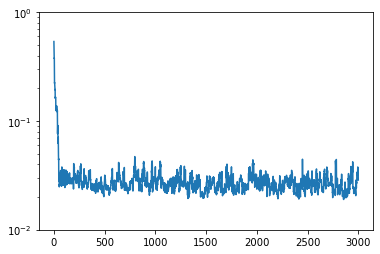

In [11]:
# Centralized method
K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
l = 150
iteration = 3000
alpha_0 = np.zeros((D,1))
alpha = alpha_0
err = []
mean_mse = []

KLMS_RFF = klms_rff(step_size,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D)

# Process data and kernel
u,d,d_true = generate_data(num_data)

mse_cent = [np.var(d)]
sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(size=(2,D))

b = np.random.uniform(0,2*np.pi,(D,1))
h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
for n in tqdm(range(iteration)):

    # Local updates
    v = np.random.randint(0,num_data)
    alpha_in = alpha
    u_k = u[v]
    h_k = h[:,v].reshape((D,1))
    d_k = np.array([d[v]])
#     err = d_k - h_k.T @ alpha_in
#     alpha_step = alpha_in + step_size  * h_k * err
    erri,alpha_step = KLMS_RFF.train(h_k,d_k,alpha_in)

    alpha = alpha_step
    mse_cent.append(np.square(np.linalg.norm(d[-500::].reshape(500,1) - h.T[-500::] @ alpha))/500)

# plt.figure(figsize=(7, 6))
plt.semilogy(range(len(mse_cent)),mse_cent)
plt.ylim([1e-2,1e0])
# plt.xlim([0,3000])

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 27503.90it/s]


(0.0, 3000.0)

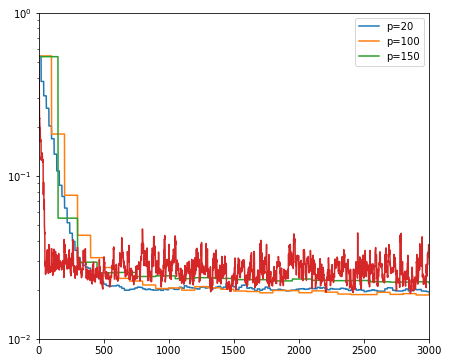

In [19]:
# Federated learning: Synchronous updating rule
plt.figure(figsize=(7, 6))
# plt.semilogy(range(len(mse_cent)),mse_cent)

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
l = [20, 100, 150]
iteration = 10000

for epoch in range(len(l)):
    alpha_0 = np.zeros((D,1))
    alpha = alpha_0
    alphas = np.zeros((K,D))
    err = []
    mean_mse = []

    # Process data and kernel
    u,d,d_true = generate_data(num_data)

    mse = [np.var(d)]
    sigma = 1/np.sqrt(2*kernel.sigma)
    W = (1/sigma) * np.random.normal(size=(2,D))

    b = np.random.uniform(0,np.pi,(D,1))
    h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
    for n in tqdm(range(iteration)):

        # Local updates
        v = np.random.randint(0,num_data)
        edge = np.random.randint(0,K)

        alpha_in = alphas[edge].reshape((D,1))
        u_k = u[v]
        h_k = h[:,v].reshape((D,1))
        d_k = np.array([d[v]])
    #     err = d_k - h_k.T @ alpha_in
    #     alpha_step = alpha_in + step_size  * h_k * err
        erri,alpha_step = KLMS_RFF.train(h_k,d_k,alpha_in)
        err.append(erri)
        alphas[edge] = alpha_step.T

        # Global update
        if n % l[epoch] == 0 and n>1:
            alpha = (alphas.T @ c)
            alphas = np.repeat(alpha,K,axis=1).T
            mse.append(np.square(np.linalg.norm(d[-500::].reshape(500,1) - h.T[-500::] @ alpha))/500)
        elif n > 1:
            mse.append(mse[-1])
    # final_mse.append(mse[0])


    plt.semilogy(range(len(mse)),mse,label="p=" + str(l[epoch]))
plt.semilogy(range(len(mse_cent)),mse_cent)
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])

In [18]:
# Federated learning: Asynchronous updating rule
K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
l = 10
iteration = 10000

final_mse = []

# Process data and kernel
u,d,d_true = generate_data(num_data)

mse = [np.var(d)]
sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(loc=0, scale=1.0, size=(2,D))
b = np.random.uniform(0,2*np.pi,(D,1))
h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

alpha_0 = np.zeros((D,1))
alpha = alpha_0
alphas = np.zeros((K,D))
last_alphas = alphas.copy()
edge_count = [ 0 for i in range(K)]
for n in tqdm(range(iteration)):

    # Local updates
    v = np.random.randint(num_data)
    edge = np.random.randint(K)
    edge_count[edge] += 1
    alpha_in = alphas[edge].reshape((D,1))
    u_k = u[v]
    h_k = h[:,v].reshape((D,1))
    d_k = np.array([d[v]])
#     err = d_k - h_k.T @ alpha_in
#     alpha_step = alpha_in + step_size  * h_k * err
    _,alpha_step = KLMS_RFF(u_k,d_k,h_k,step_size,D,alpha_0=alpha_in)

    alphas[edge] = alpha_step.T

    # Global update
    if edge_count[edge] % l == 0 and n>1:
        alpha += (alphas[edge] - last_alphas[edge]).reshape((D,1))/l
        alphas[edge] = alpha.reshape((D,))
        last_alphas[edge] = alphas[edge]
        mse.append(np.square(np.linalg.norm(d[-500::].reshape(500,1) - h.T[-500::] @ alpha))/500)
        edge_count[edge] = 0
    
    elif n > 1:
        mse.append(mse[-1])
# final_mse.append(mse[0])

plt.figure(figsize=(7, 6))
plt.semilogy(range(len(mse)),mse)
plt.ylim([1e-2,.6])
# plt.xlim([0,3000])

  0%|                                                 | 0/10000 [00:00<?, ?it/s]


TypeError: 'klms_rff' object is not callable

In [54]:
mse[0::500]

[0.5417827302165823,
 0.029256667123112583,
 0.027052609229140843,
 0.027458593312713334,
 0.02918008673976943,
 0.025095406667571922,
 0.0278366199092296,
 0.025281021700026492,
 0.02423330516008425,
 0.024481027797950392,
 0.023895427420914286,
 0.02440693433691005,
 0.02674569172821225,
 0.02579276609304372,
 0.023779834307902807,
 0.026190944812969377,
 0.02388628219607103,
 0.02430406085406279,
 0.024875654081228195,
 0.024400341010043354]